### 0. Set-up

In [139]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, pointbiserialr, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn. metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV

### 1. Load Data

In [4]:
CSV_PATH_CANDIDATES = [
    '/Users/rohilzalke/Desktop/DataSet/Telcom-Customer-Churn.csv'  
]

csv_path = None
for p in CSV_PATH_CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'housing.csv'. Place it in the notebook folder or update CSV_PATH_CANDIDATES.")

df = pd.read_csv(csv_path)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 2. Quick Data Check-up

In [6]:
print("Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nMissing values per columns:")
print(df.isnull().sum())
print("\nBasics Statisitcs:")
print(df.describe())

Shape: (7043, 21)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessB

### 3. Data Preprocessing

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [9]:
df['TotalCharges'].isnull().sum()

11

In [10]:
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

/var/folders/n6/ppd8n6ys41zg2knlk802_jx40000gn/T/ipykernel_49007/1854230864.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


### 4. Statistics 

In [13]:
cat = df.select_dtypes(include=['object']).columns

chi_results = {}
for i in cat: 
    table = pd.crosstab(df[i], df['Churn'])
    chi2, p, _,_ = chi2_contingency(table)
    chi_results[i] = {'Chi Value': chi2, 'p-value': p}


sorted_chi = dict(sorted(chi_results.items(), key=lambda x: x[1]['Chi Value'], reverse=True)) # Sort by Chi Value (highest first)
for feature, stats in sorted_chi.items():
    print(f"{feature}: Chi Value = {stats['Chi Value']}, p-value = {stats['p-value']}")


customerID: Chi Value = 7043.0, p-value = 0.49439767459438705
Churn: Chi Value = 7037.871379458012, p-value = 0.0
Contract: Chi Value = 1184.5965720837926, p-value = 5.863038300673393e-258
OnlineSecurity: Chi Value = 849.9989679615965, p-value = 2.661149635176552e-185
TechSupport: Chi Value = 828.1970684587394, p-value = 1.4430840279998987e-180
InternetService: Chi Value = 732.309589667794, p-value = 9.571788222840544e-160
PaymentMethod: Chi Value = 648.1423274814, p-value = 3.6823546520098007e-140
OnlineBackup: Chi Value = 601.812790113409, p-value = 2.079759216086427e-131
DeviceProtection: Chi Value = 558.419369407389, p-value = 5.505219496457244e-122
StreamingMovies: Chi Value = 375.6614793452656, p-value = 2.667756755723681e-82
StreamingTV: Chi Value = 374.2039433109813, p-value = 5.528994485739183e-82
PaperlessBilling: Chi Value = 258.27764906707307, p-value = 4.0733546686659864e-58
Dependents: Chi Value = 189.12924940423474, p-value = 4.924921661215422e-43
Partner: Chi Value = 15

### High Chi square value + extremely low p-value are Strongest Predictors of wether a customer will chirt or not

/var/folders/n6/ppd8n6ys41zg2knlk802_jx40000gn/T/ipykernel_49007/1183649342.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mod = df.replace({'Churn': {'Yes': 1, 'No': 0}})


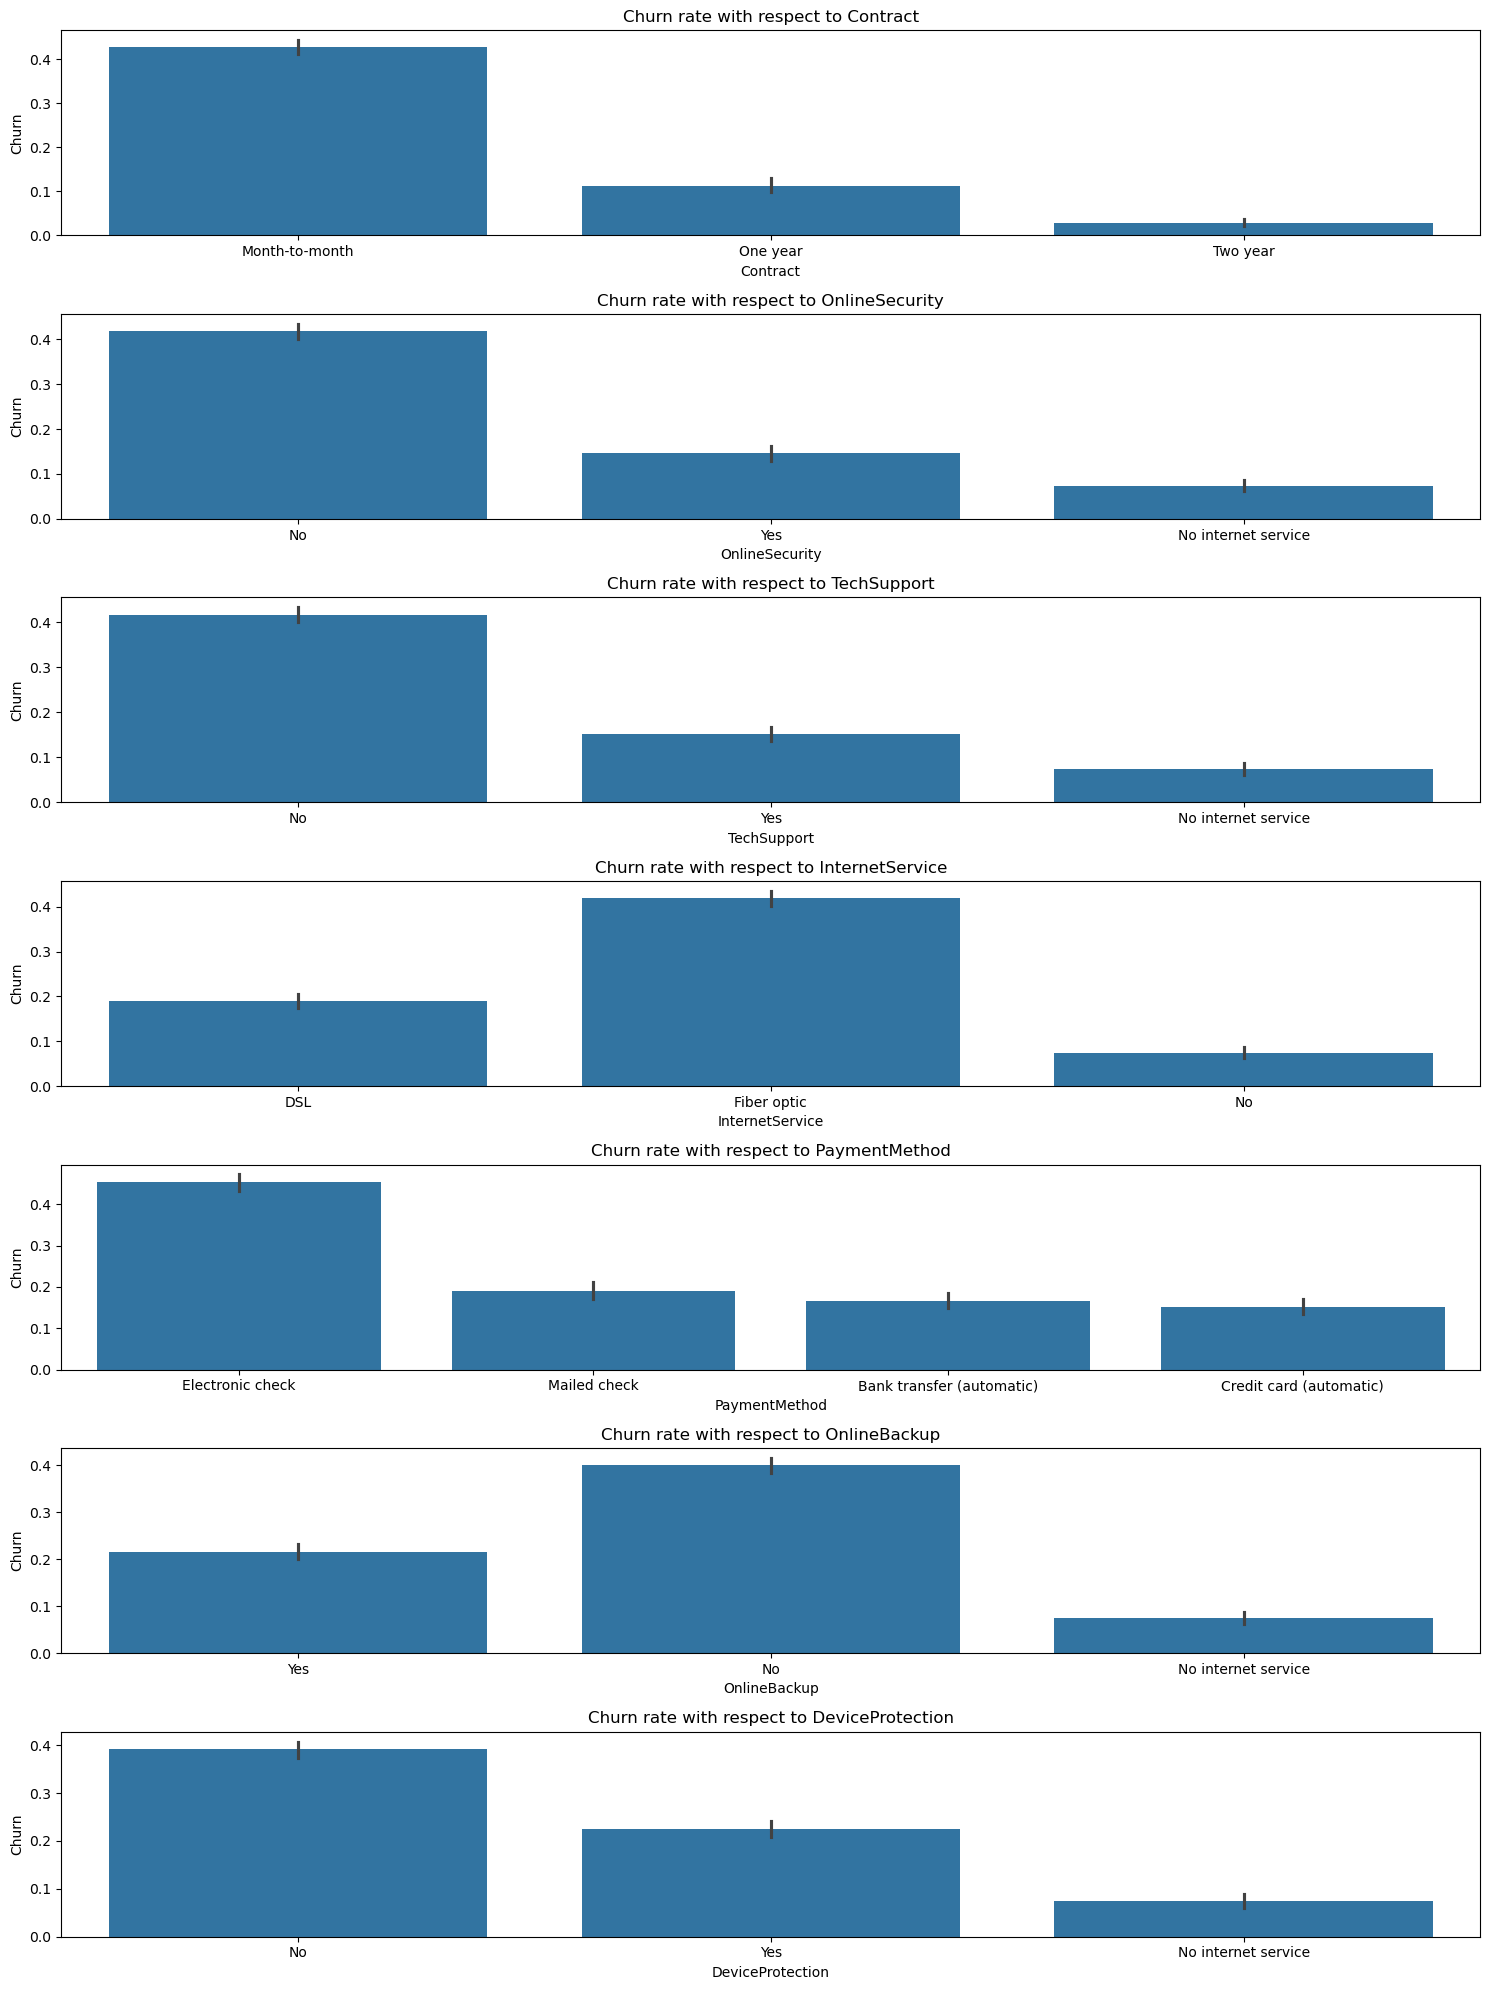

In [15]:
plt.figure(figsize=(15, 20))
df_mod = df.replace({'Churn': {'Yes': 1, 'No': 0}})
l = ['Contract', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod', 'OnlineBackup', 'DeviceProtection']
for idx, col in enumerate(l,1): 
    plt.subplot(len(l), 1, idx) # creates a subplot
    sns.barplot(x=col, y='Churn', data = df_mod, estimator=np.mean)
    plt.title(f"Churn rate with respect to {col}")
    
plt.tight_layout()
plt.show()

In [16]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
corr_results = {}
for i in num_features:
    corr, p_value = pointbiserialr(df[i], df['Churn'].map({'Yes': 1, 'No': 0}))
    corr_results[i] = {'Correlation': corr, 'P-Value': p_value}

corr_results

{'tenure': {'Correlation': -0.35222867011310205,
  'P-Value': 7.999057960045526e-205},
 'MonthlyCharges': {'Correlation': 0.1933564222378591,
  'P-Value': 2.706645606843024e-60},
 'TotalCharges': {'Correlation': -0.19942771508832596,
  'P-Value': 4.2338363848050186e-64}}

#### Tenure and TotalCharges show a slight negative correlation, which means that if a customer stays longer with the company and spends more they are less likely to churn

#### MonthlyCharges shows a slight positive correlation which means that the more monthly charges the customer pays, more likely he/ she will churn

<Axes: xlabel='tenure', ylabel='TotalCharges'>

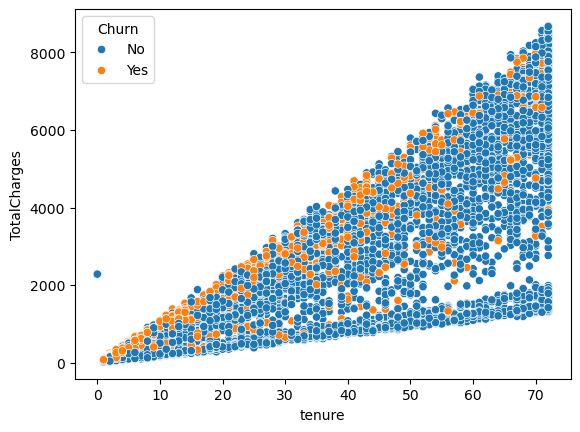

In [18]:
sns.scatterplot(x='tenure', y='TotalCharges', hue = 'Churn', data=df)

<Axes: xlabel='Churn', ylabel='MonthlyCharges'>

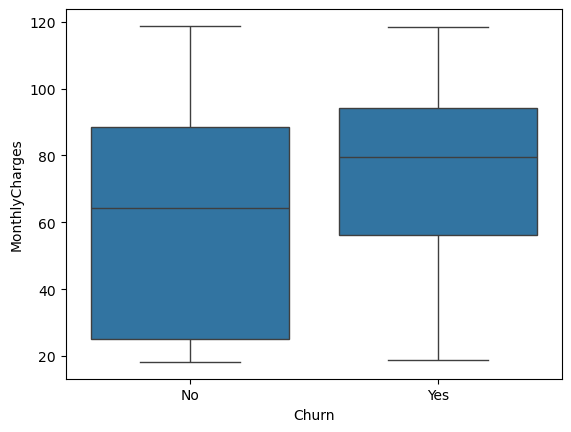

In [19]:
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df)

In [20]:
df_new = df.copy()
df_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


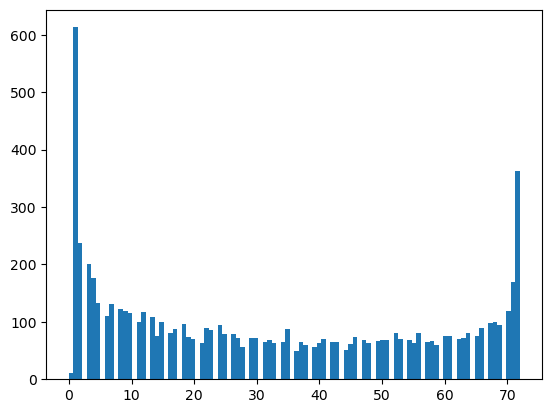

In [21]:
plt.hist(df_new['tenure'], bins=100)
plt.show()

In [22]:
df_new['Tenure_group'] = pd.cut(df_new['tenure'], bins = [0,10,20,30,40,50,60,70], labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70'])

<Axes: xlabel='Tenure_group', ylabel='count'>

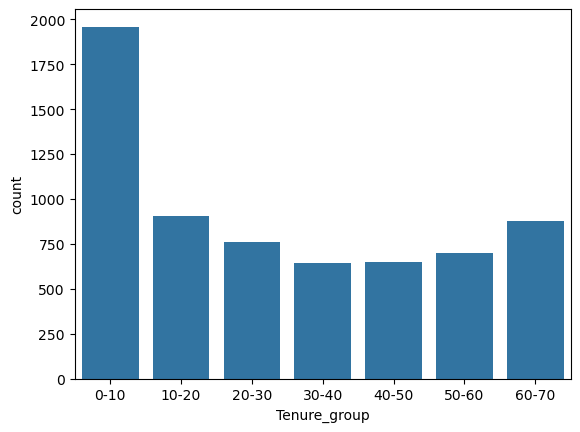

In [23]:
sns.countplot(x = 'Tenure_group', data = df_new)

<Axes: xlabel='tenure', ylabel='Tenure_group'>

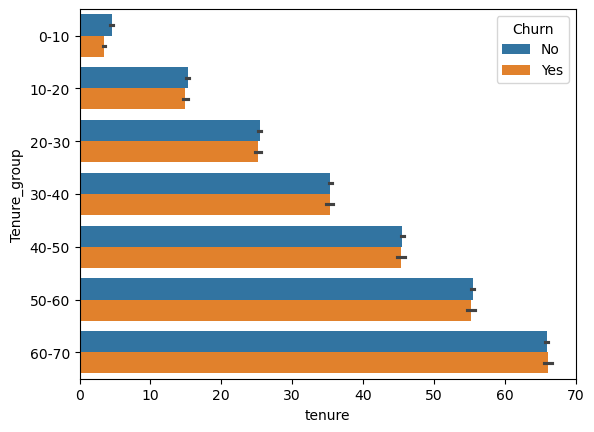

In [24]:
df_new['Tenure_group'].isnull().sum()

df_new.dropna(axis=0, inplace=True)

sns.barplot(x='tenure', y='Tenure_group', hue='Churn', data=df_new)

In [25]:
X = df[['Contract', 'OnlineSecurity', 'TechSupport', 'InternetService', 'PaymentMethod', 'OnlineBackup', 'DeviceProtection', 'StreamingMovies', 'StreamingTV', 'PaperlessBilling', 'Partner']]
y = df['Churn'].map({'Yes': 1, 'No': 0})
print("Original y shape:", y.shape)
print("y value counts:")
print(y.value_counts())
print("\nColumn Info:")
print(X.info())

X_processed = pd.get_dummies(X, drop_first=True)
print("Processed X shape:", X_processed.shape)
print("X_processed dtypes:")
print(X_processed.dtypes)

# Handle any missing values
X_processed = X_processed.dropna()
y = y.loc[X_processed.index]  # Align y with processed X

X_processed = X_processed.astype(float)
y = y.astype(float)

print("Final aligned shapes:")
print("X_processed:", X_processed.shape)
print("y:", y.shape)

logit_model = sm.GLM(y, sm.add_constant(X_processed), family=sm.families.Binomial()).fit()
print(logit_model.summary())



Original y shape: (7043,)
y value counts:
Churn
0    5174
1    1869
Name: count, dtype: int64

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Contract          7043 non-null   object
 1   OnlineSecurity    7043 non-null   object
 2   TechSupport       7043 non-null   object
 3   InternetService   7043 non-null   object
 4   PaymentMethod     7043 non-null   object
 5   OnlineBackup      7043 non-null   object
 6   DeviceProtection  7043 non-null   object
 7   StreamingMovies   7043 non-null   object
 8   StreamingTV       7043 non-null   object
 9   PaperlessBilling  7043 non-null   object
 10  Partner           7043 non-null   object
dtypes: object(11)
memory usage: 605.4+ KB
None
Processed X shape: (7043, 21)
X_processed dtypes:
Contract_One year                        bool
Contract_Two year                        bo

#### positive coef = increases likelihood of churn & negative coef = decreases likelihood of churn

##### 1) Contract:  
  ###### One year (coef = -1.23, highly significant): customers with a one-year contract are less likely to churn compared to month-to-month (baseline).
  ###### Two year (coef = -2.25): even less likely to churn.
  ###### Which means that Longer contracts = stickier customers.

##### 2) InternetService
  ###### Fiber optic (coef = +0.698): customers with fiber are more likely to churn than DSL (baseline).
  ###### No internet service (coef = -0.156): much less likely to churn (makes sense, they’re not really internet customers).

##### 3) PaymentMethod
  ###### Electronic check (coef = +0.49, sig): strongly linked with higher churn.
  ###### Mailed check (coef = +0.22, weakly sig).
  ###### Credit card (automatic) (coef = -0.076, not significant).
  ###### Manual/electronic check payments = higher churn risk.

##### 3. Streaming services
  ###### StreamingMovies_Yes (+0.18, sig) and StreamingTV_Yes (+0.17, sig): having streaming slightly increases churn.
  ###### But if “No internet service”, they’re in the -0.156 group (much less likely to churn).

##### 4. PaperlessBilling
  ###### Yes (+0.319, sig): paperless billing customers are more likely to churn.

##### 5. Partner
  ###### Yes (-0.265, sig): customers with a partner are less likely to churn.

##### Insights for Business
  ###### Retention levers: Encourage customers to switch from month-to-month → yearly contracts.
  ###### Bundle online security / tech support → reduces churn.
  ###### Focus retention campaigns on fiber optic users (they’re more prone to churn).
  ###### Customers paying by electronic check → high churn risk group.
  
  ##### Less important features (p > 0.05): DeviceProtection_Yes (borderline insignificant) & Credit card (automatic) → no strong effect.

##### std err (Standard Error): Tells you how much uncertainty is in the coefficient estimate. Smaller std err → the estimate is more precise.

##### z (z-statistic): Test statistic = coef / std err. It tells you how many standard errors the coefficient is away from zero. Large |z| values → strong evidence the coefficient is not zero.

##### P>|z| (p-value): If p < 0.05 → statistically significant.

#### Odds Ratios

In [28]:
odds_ratios = np.exp(logit_model.params)
print("Odds Ratios:\n", odds_ratios)

Odds Ratios:
 const                                    0.452754
Contract_One year                        0.290655
Contract_Two year                        0.105035
OnlineSecurity_No internet service       0.855486
OnlineSecurity_Yes                       0.578195
TechSupport_No internet service          0.855486
TechSupport_Yes                          0.653561
InternetService_Fiber optic              2.009656
InternetService_No                       0.855486
PaymentMethod_Credit card (automatic)    0.926545
PaymentMethod_Electronic check           1.632856
PaymentMethod_Mailed check               1.251058
OnlineBackup_No internet service         0.855486
OnlineBackup_Yes                         0.688862
DeviceProtection_No internet service     0.855486
DeviceProtection_Yes                     0.866921
StreamingMovies_No internet service      0.855486
StreamingMovies_Yes                      1.201859
StreamingTV_No internet service          0.855486
StreamingTV_Yes                     

#### Odds ratios are much easier to interpret in a business context.
##### You can directly say:
##### OR > 1 → increases churn likelihood
##### OR < 1 → decreases churn likelihood
##### OR = 1 → no effect

#### Checking Multicollinearity Using Variance Inflation Factor (VIF) will help you identify redundant predictors

In [31]:
# 
X_const = sm.add_constant(X_processed)
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) 
                   for i in range(X_const.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))



                                  feature           VIF
3      OnlineSecurity_No internet service  1.377248e+13
16    StreamingMovies_No internet service  3.445753e+12
12       OnlineBackup_No internet service  1.531055e+12
5         TechSupport_No internet service  4.768338e+10
14   DeviceProtection_No internet service  2.482862e+09
18        StreamingTV_No internet service  1.510979e+09
8                      InternetService_No  7.450532e+08
0                                   const  1.327647e+01
10         PaymentMethod_Electronic check  1.938794e+00
2                       Contract_Two year  1.852711e+00
11             PaymentMethod_Mailed check  1.752561e+00
17                    StreamingMovies_Yes  1.619053e+00
19                        StreamingTV_Yes  1.617077e+00
7             InternetService_Fiber optic  1.574383e+00
9   PaymentMethod_Credit card (automatic)  1.558675e+00
6                         TechSupport_Yes  1.470114e+00
15                   DeviceProtection_Yes  1.461

#### VIF = 1 → no correlation.
#### VIF < 5 → okay.
#### VIF > 10 → multicollinearity problem.

##### Removing high-VIF (>10) features helps in the following ways:
  ###### Stabilizes model → coefficients stop flipping signs randomly.
  ###### Improves interpretability → you can say with confidence which features matter.
  ###### Reduces redundancy → removes duplicate information (like your “No internet service” dummies).
  ###### Prevents numerical errors → ensures the matrix inversion works smoothly.

In [33]:
to_drop = ['OnlineSecurity_No internet service', 'StreamingMovies_No internet service', 
'OnlineBackup_No internet service', 'TechSupport_No internet service', 'DeviceProtection_No internet service',
'StreamingTV_No internet service', 'InternetService_No']

X_processed_new = X_processed.drop(columns = to_drop)
#Rechecking VIF
X_const = sm.add_constant(X_processed_new)
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) 
                   for i in range(X_const.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

                                  feature        VIF
0                                   const  10.078617
7          PaymentMethod_Electronic check   1.925867
8              PaymentMethod_Mailed check   1.737085
12                        StreamingTV_Yes   1.598753
11                    StreamingMovies_Yes   1.597551
2                       Contract_Two year   1.563984
6   PaymentMethod_Credit card (automatic)   1.559218
5             InternetService_Fiber optic   1.472884
10                   DeviceProtection_Yes   1.410081
4                         TechSupport_Yes   1.358389
1                       Contract_One year   1.280525
9                        OnlineBackup_Yes   1.256305
3                      OnlineSecurity_Yes   1.249840
13                   PaperlessBilling_Yes   1.186228
14                            Partner_Yes   1.124983


### 5. Train-Test Split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_new, y, test_size=0.3, random_state=42, stratify=y)

In [141]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 6. Logistic Regression Model

##### Baseline Logistic Regression

In [181]:
LogR = LogisticRegression(class_weight='balanced', max_iter=1000)
LogR.fit(X_train, y_train)

y_pred = LogR.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79      1552
         1.0       0.49      0.79      0.60       561

    accuracy                           0.72      2113
   macro avg       0.69      0.74      0.69      2113
weighted avg       0.79      0.72      0.74      2113



##### Precision = out of all predicted positives, how many are truly positive
##### Recall = out of all actual positives, how many were correctly predicted
##### F1 = harmonic mean of Precision & Recall
##### Accuracy = Overall accuracy

##### Baseline Logistic Regression

In [177]:
for penalty in ['l1', 'l2']:
    clf = LogisticRegression(
        penalty=penalty,
        solver='saga',
        max_iter=1000,
        class_weight='balanced'
    )
    clf.fit(X_train, y_train)
    pred = clf.predict_proba(X_test)[:, 1]   # take only positive class probs
    print(f"{penalty} Penalty - Test AUC:", roc_auc_score(y_test, pred))

l1 Penalty - Test AUC: 0.8172423139827627
l2 Penalty - Test AUC: 0.8173238601907492


### 7. Model Evaluation

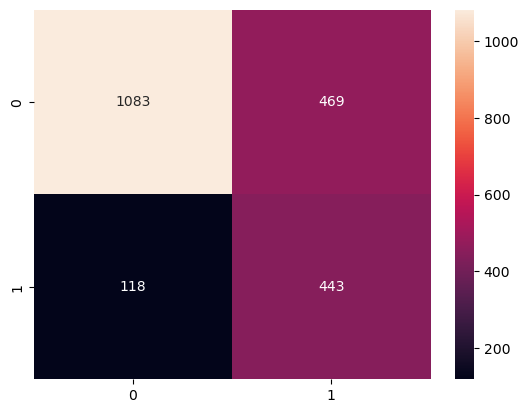

In [155]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

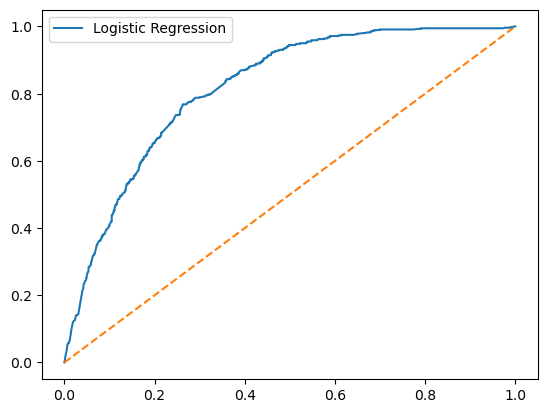

In [157]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, LogR.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

### 8. Hyperparameter Tunning

In [159]:
grid_para = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(solver = 'saga', max_iter = 1000), grid_para, cv=5, scoring = 'roc_auc' )
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'C': 1.0, 'penalty': 'l2'}


In [173]:
clf1 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=1000)
clf1.fit(X_train, y_train)

pred = clf1.predict_proba(X_test)[:, 1]   # only take probability for positive class
print("L2 Penalty - Test AUC:", roc_auc_score(y_test, pred))

L2 Penalty - Test AUC: 0.8184827351746697
